# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer,make_column_selector
from imblearn.over_sampling import SMOTE

## Load Dataset

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = df.drop('Outcome',axis=1)
y = df.Outcome

## 🔎 EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Replace zero values with NaN
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI']].replace(0, np.nan)

In [7]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

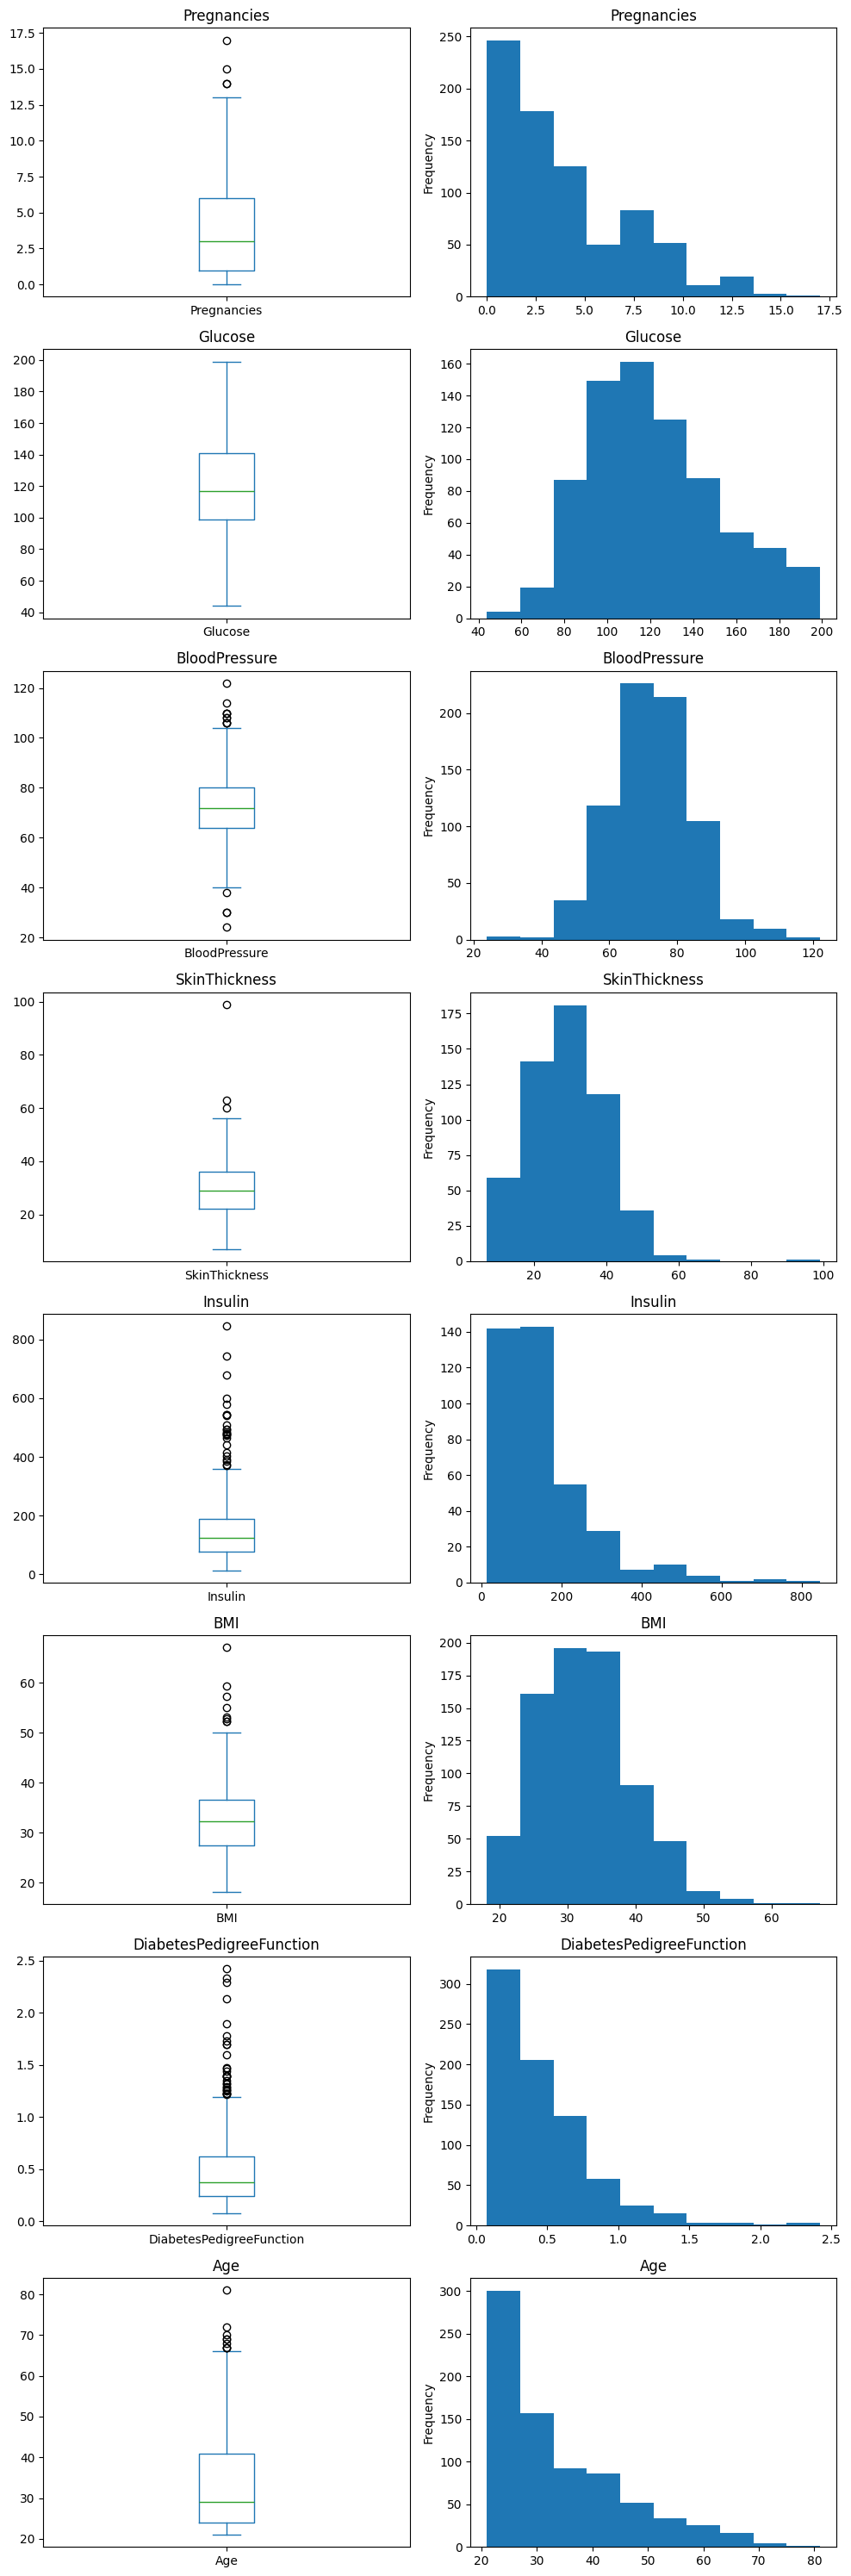

In [8]:
# Check for distribution and outliers
fig, axes = plt.subplots(8, 2, figsize=(10, 30))
axes = axes.flatten()
ax_idx = 0

for col in X.columns:
    df[col].plot(kind = 'box', ax = axes[ax_idx], title = col)
    ax_idx += 1
    df[col].plot(kind = 'hist', ax = axes[ax_idx], title = col)
    ax_idx += 1
    
plt.tight_layout()
plt.show()

## Train Test Split

In [9]:
test_size = 0.2
random_state =42

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [11]:
# Checking target's balance
y_train.value_counts()

Outcome
0    401
1    213
Name: count, dtype: int64

# Preprocessing Pipeline

In [12]:
preproc = make_pipeline(
    SimpleImputer(),
    RobustScaler()           
    )
preproc

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('robustscaler', RobustScaler())])

In [13]:
X_train_preproc = preproc.fit_transform(X_train)

## Oversampling the Train Data

In [14]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()

(802, 8)
(802,)


Outcome
0    401
1    401
Name: count, dtype: int64

# Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)


LogisticRegression()

In [16]:
X_test_preproc = preproc.transform(X_test)

## Training and Evaluation

In [17]:
# Make predictions
y_pred = lr.predict(X_test_preproc)

# Score model
score = accuracy_score(y_test, y_pred)
print(f'🎯Accuracy score is {round(score, 2)}')

🎯Accuracy score is 0.71


# 🌲Decision Tree

In [18]:
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(X_train_res, y_train_res)

DecisionTreeClassifier(max_depth=2)

## Training and Evaluation

In [19]:
# Make predictions
y_pred = dtc.predict(X_test_preproc)

# Score model
score = accuracy_score(y_test, y_pred)
print(f'🎯Accuracy score is {round(score, 2)}')

🎯Accuracy score is 0.62


# RandomForest Classifier

In [20]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=0)

## Training and Evaluation

In [21]:
# Make predictions
y_pred = rfc.predict(X_test_preproc)

# Score model
score = accuracy_score(y_test, y_pred)
print(f'🎯Accuracy score is {round(score, 2)}')

🎯Accuracy score is 0.73


# GridSearchCV

In [22]:
rfc = RandomForestClassifier()

In [23]:
param = {
    'max_depth':[1,2,3,4,5,10,20,30],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [24]:
%%time
grid_search = GridSearchCV(estimator=rfc,
                   param_grid=param,
                   cv = 4,
                   n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train_res, y_train_res)

Fitting 4 folds for each of 144 candidates, totalling 576 fits
CPU times: user 603 ms, sys: 121 ms, total: 724 ms
Wall time: 9.92 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [30]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_leaf': 1,
 'n_estimators': 50}

In [25]:
grid_search.best_score_

0.8430161691542288

In [26]:
rfc_best = grid_search.best_estimator_
rfc_best

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)

## Training and Evaluation

In [27]:
# Make predictions
y_pred = rfc_best.predict(X_test_preproc)

# Score model
score = accuracy_score(y_test, y_pred)
print(f'🎯Accuracy score is {round(score, 2)}')

🎯Accuracy score is 0.73


In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        99
           1       0.61      0.73      0.66        55

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



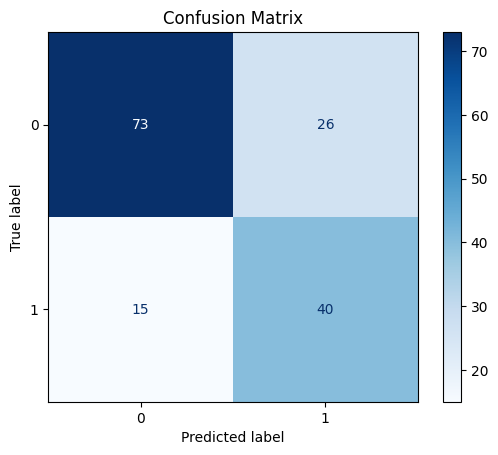

In [29]:
# Instantiate Confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Instantiate ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()